This is where I keep all the charts that I used in my report.

First I want to import seaborn, as it allows us to make beautiful plots
Also import pyplot

And I import the data and functions. (need to install ipynb)

In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for legend handle in the 2nd plot

# ! pip install ipynb
from ipynb.fs.full.Data import *
from ipynb.fs.full.Functions import *

I want to readout my test data first by doing this:
<br>
I add all the data into 1 dictionary, to be easily accessible

In [2]:
tests = [test_1, test_2, test_3]
data = []

for test in tests:
    resistor, distance_lamp_to_box, distance_box_to_detector, start_test, humidity, dark_voltage, light_voltage, temperature, \
    voltage_gain = test_data_reader(test)

    data.append({"resistor": resistor, "distance_lamp_to_box": distance_lamp_to_box,
                 "distance_box_to_detector": distance_box_to_detector, "start_test":start_test, "humidity": humidity,
                 "dark_voltage": dark_voltage,
                 "light_voltage": light_voltage, "temperature": temperature, "voltage_gain": voltage_gain})


Lets start with our first plot that will show all the data at once.

The 3 tests differ by 2 things.
1. the resistor changes
2. the distance from the lamp to the lid of the box

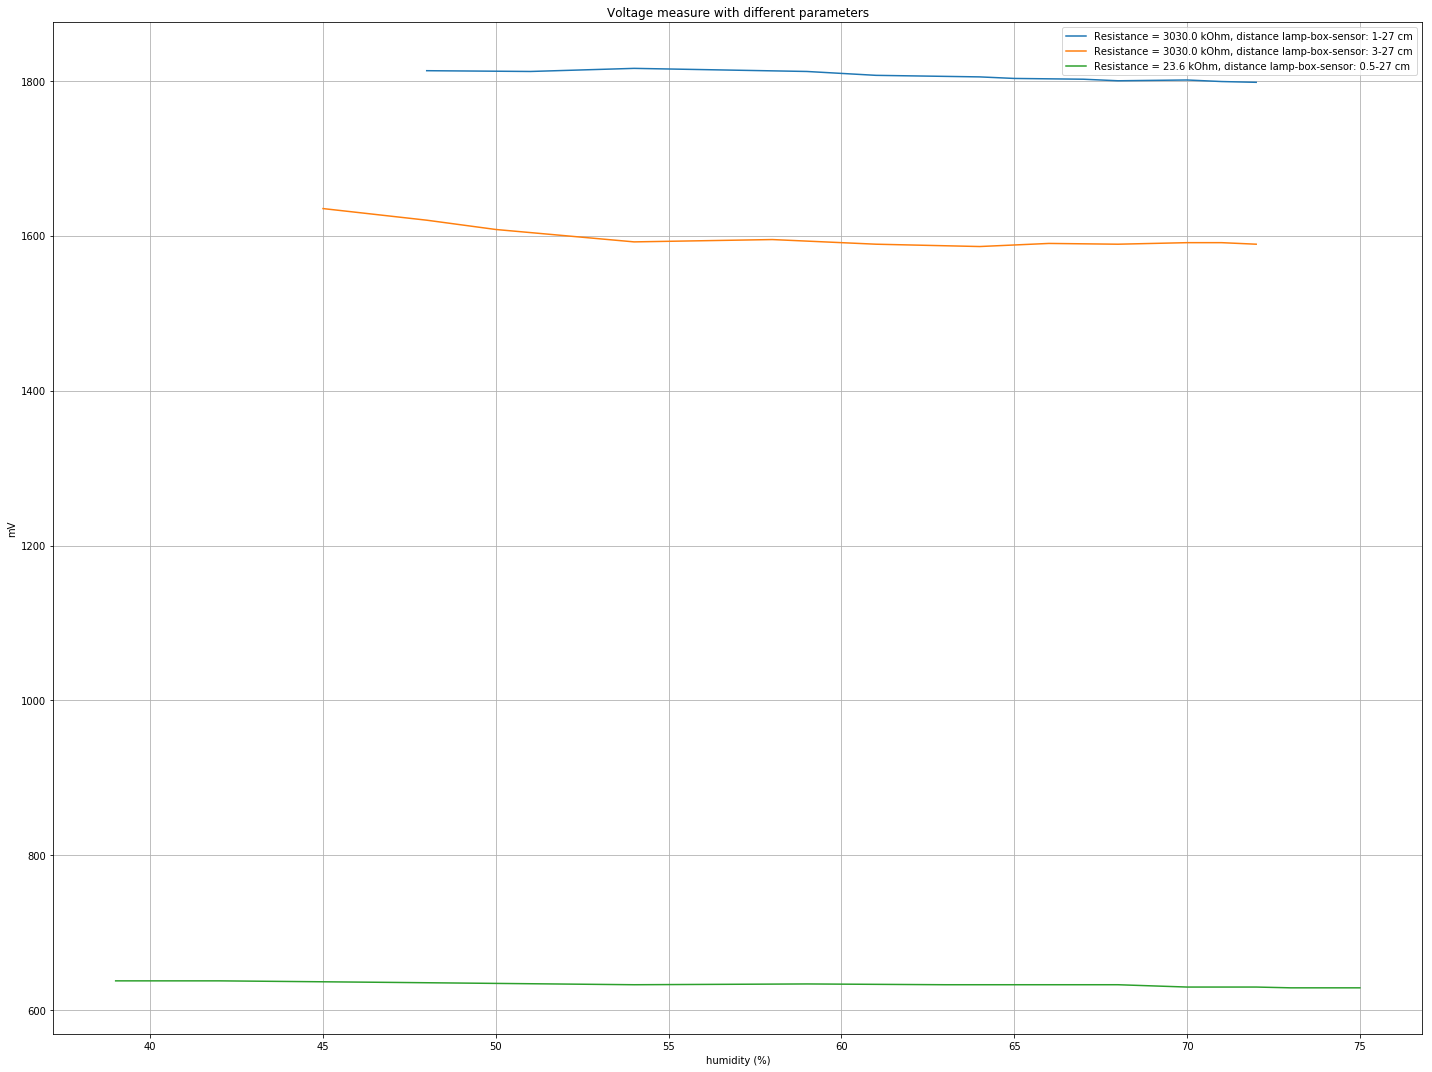

In [3]:
plt.rcParams["figure.figsize"] = (20, 15)

for i in range(len(data)):
    x = data[i]["humidity"]
    y = data[i]["voltage_gain"]
    plt.plot(x, y, label=f'Resistance = {data[i]["resistor"] / 1000} kOhm, distance lamp-box-sensor: '
                     f'{data[i]["distance_lamp_to_box"]}-{data[i]["distance_box_to_detector"]} cm')

plt.title(f'Voltage measure with different parameters')
plt.grid()
plt.xlabel(f'humidity (%)')
plt.ylabel('mV')
plt.legend()
plt.tight_layout()
# plt.savefig("data_better")
plt.show()

Now we will look at the 3 different seperatly, because as you can see the plot above is unreadable.

explaining the code: (line by line)<br>
1. first of all I create a figure with the same amount of subplots as datasets I have, using "sharex" to allign the humidity axis.
3. filling the plots, per data set
4. creating the x-axis, which takes the humidity list from the dataset
5. y-axis, takes the data list from the dataset, which is the voltage read from the voltmeter with the lamp on, minus the voltage read with the lamp off.
6. I also want to show temperature
7. this line takes the function that leaves a dict of color and a list of the colors. The dict looks as follows: [RGB]:color. I had to make my own color scheme for this plot, the same goes for the legend, thats why this is here.
8. plots the data per test in the correct subplot
9. same as 8.
10. these are the handles for the legend of the color in the plots
11. actually putting in the legend
12. the title for the plots, the lamp-box-sensor means; the lamp was above the boxlid, so the distance from the lamp to the box lid is the first number, and then the distance from the lid to the sensor is the 27 cm.
13. adding a grid
14. xlabel
15. ylabel
17. same as line 18-19, putting in a y range for 55 millivolt
21. giving the subplots enough space.
22. saving the plot
23. showing the plot

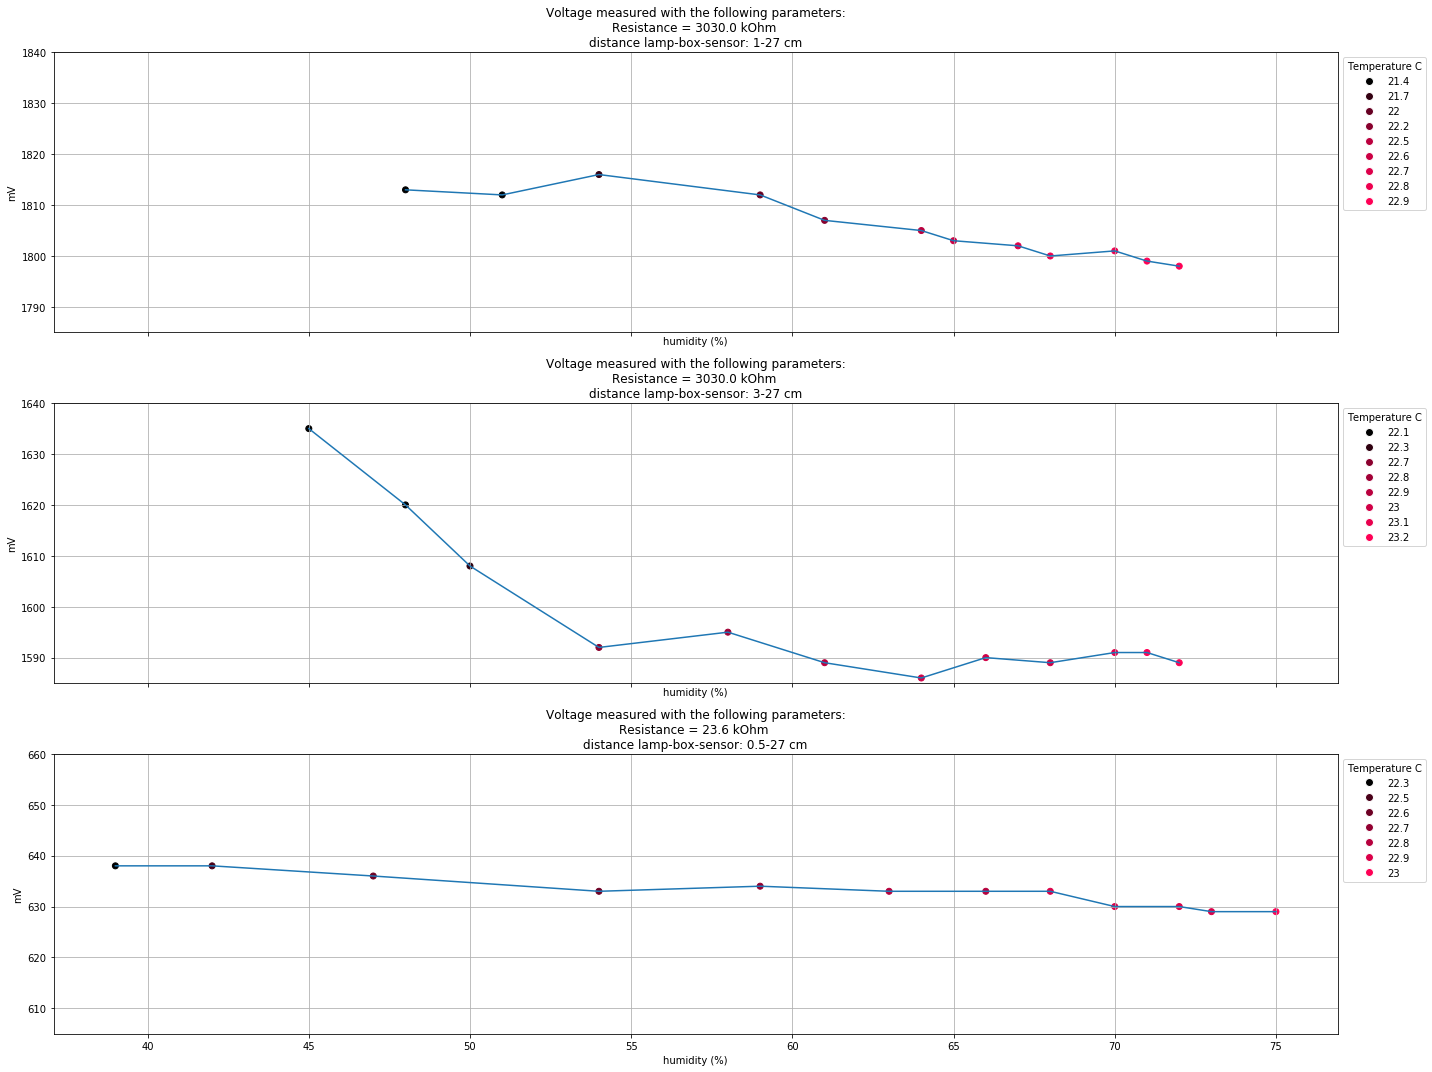

In [4]:
fig, axs = plt.subplots(len(data), figsize=(20, 15), sharex=True)

for i in range(len(data)):
    x = data[i]["humidity"]
    y = data[i]["voltage_gain"]
    temp = data[i]["temperature"]
    color_dict, color = color_magic(temp)
    axs[i].plot(x, y)
    axs[i].scatter(x, y, c=color)
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in
               color_dict.items()]
    axs[i].legend(title='Temperature C', handles=handles, bbox_to_anchor=(1, 1), loc='upper left')

    axs[i].set_title(f'Voltage measured with the following parameters:\n'
                     f'Resistance = {data[i]["resistor"] / 1000} kOhm \n'
                     f'distance lamp-box-sensor: {data[i]["distance_lamp_to_box"]}-{data[i]["distance_box_to_detector"]} cm')
    axs[i].grid()
    axs[i].set_xlabel(f'humidity (%)')
    axs[i].set_ylabel('mV')

axs[0].set_ylim([1785, 1840])
axs[1].set_ylim([1585, 1640])
axs[2].set_ylim([605, 660])

plt.tight_layout()
plt.savefig("Results")
plt.show()

For now the seaborn plot. (welke is beter denk je Rolf?)

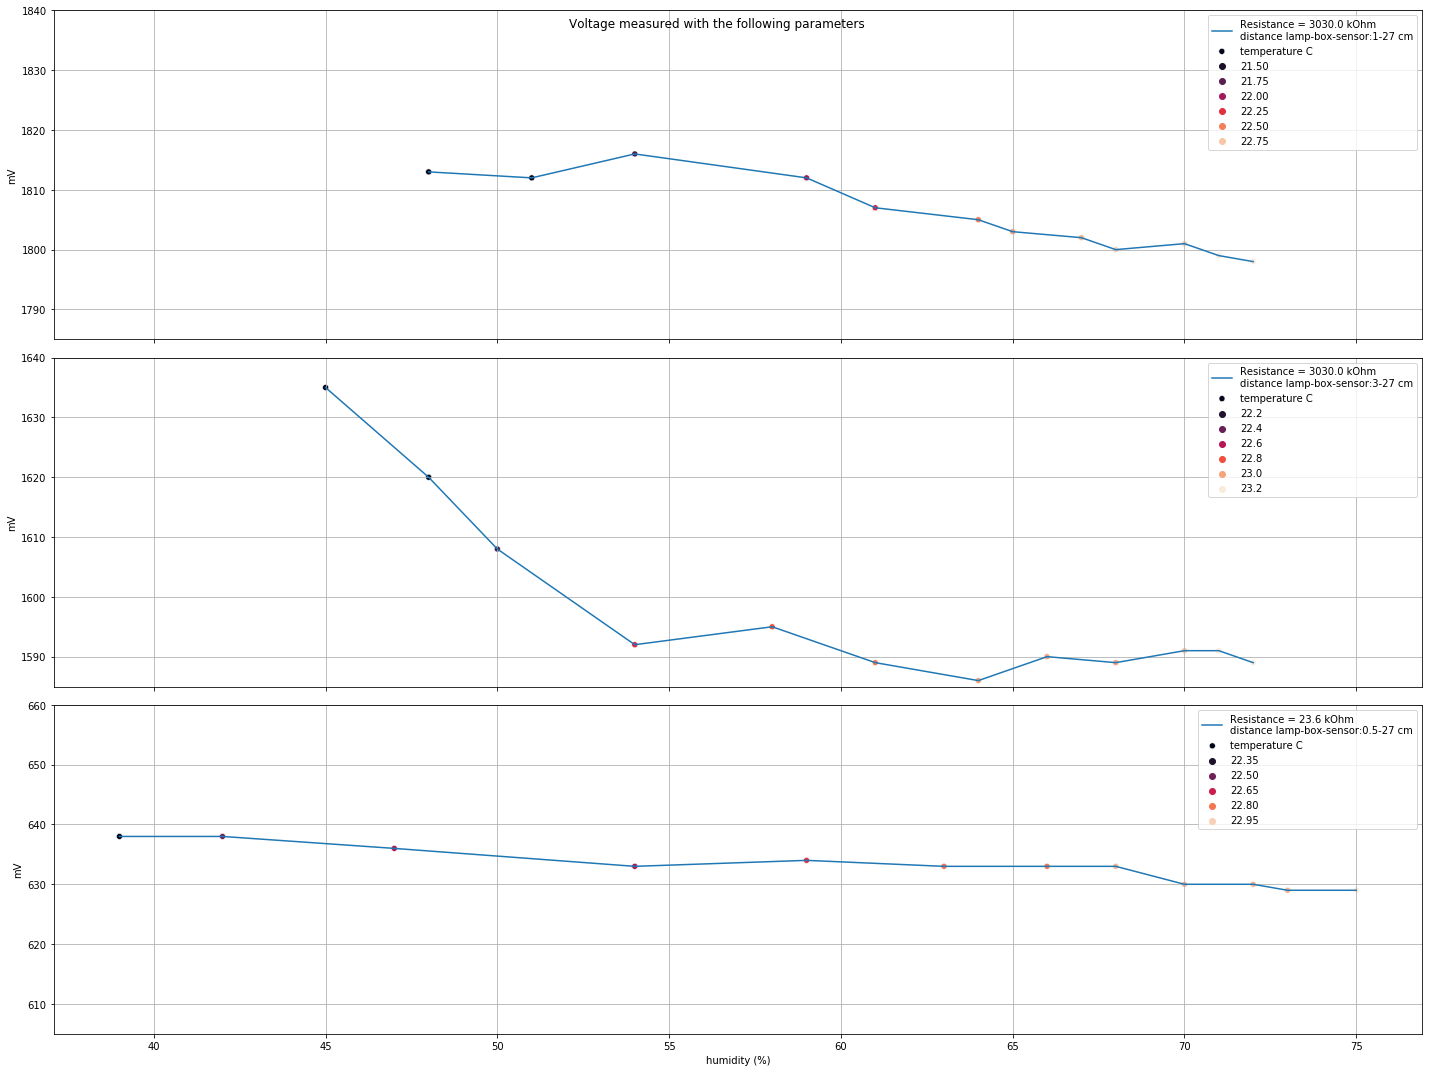

In [5]:
fig, axs = plt.subplots(len(data), figsize=(20, 15), sharex=True)
fig.suptitle('Voltage measured with the following parameters')

for i in range(len(data)):
    x = data[i]["humidity"]
    y = data[i]["voltage_gain"]
    temp = data[i]["temperature"]
    sns.lineplot(ax=axs[i], x=x, y=y, label=f'Resistance = {data[i]["resistor"] / 1000} kOhm \ndistance lamp-box-sensor:'
    f'{data[i]["distance_lamp_to_box"]}-{data[i]["distance_box_to_detector"]} cm')
    sns.scatterplot(ax=axs[i], x=x, y=y, hue=temp, palette="rocket", label="temperature C")
    axs[i].grid()
    axs[i].set_xlabel(f'humidity (%)')
    axs[i].set_ylabel('mV')

axs[0].set_ylim([1785, 1840])
axs[1].set_ylim([1585, 1640])
axs[2].set_ylim([605, 660])

plt.tight_layout()
plt.savefig("Results_seaborn")
plt.show()

Now lets take a look at the voltage that I measured with the lamp turned off, before the measurement. We will call it the dark voltage from now on, to make it a bit easier.

I am basically using the same code as before, but now I change line 5, with dark_voltage, adding the starting time of the experiment and removing the range.

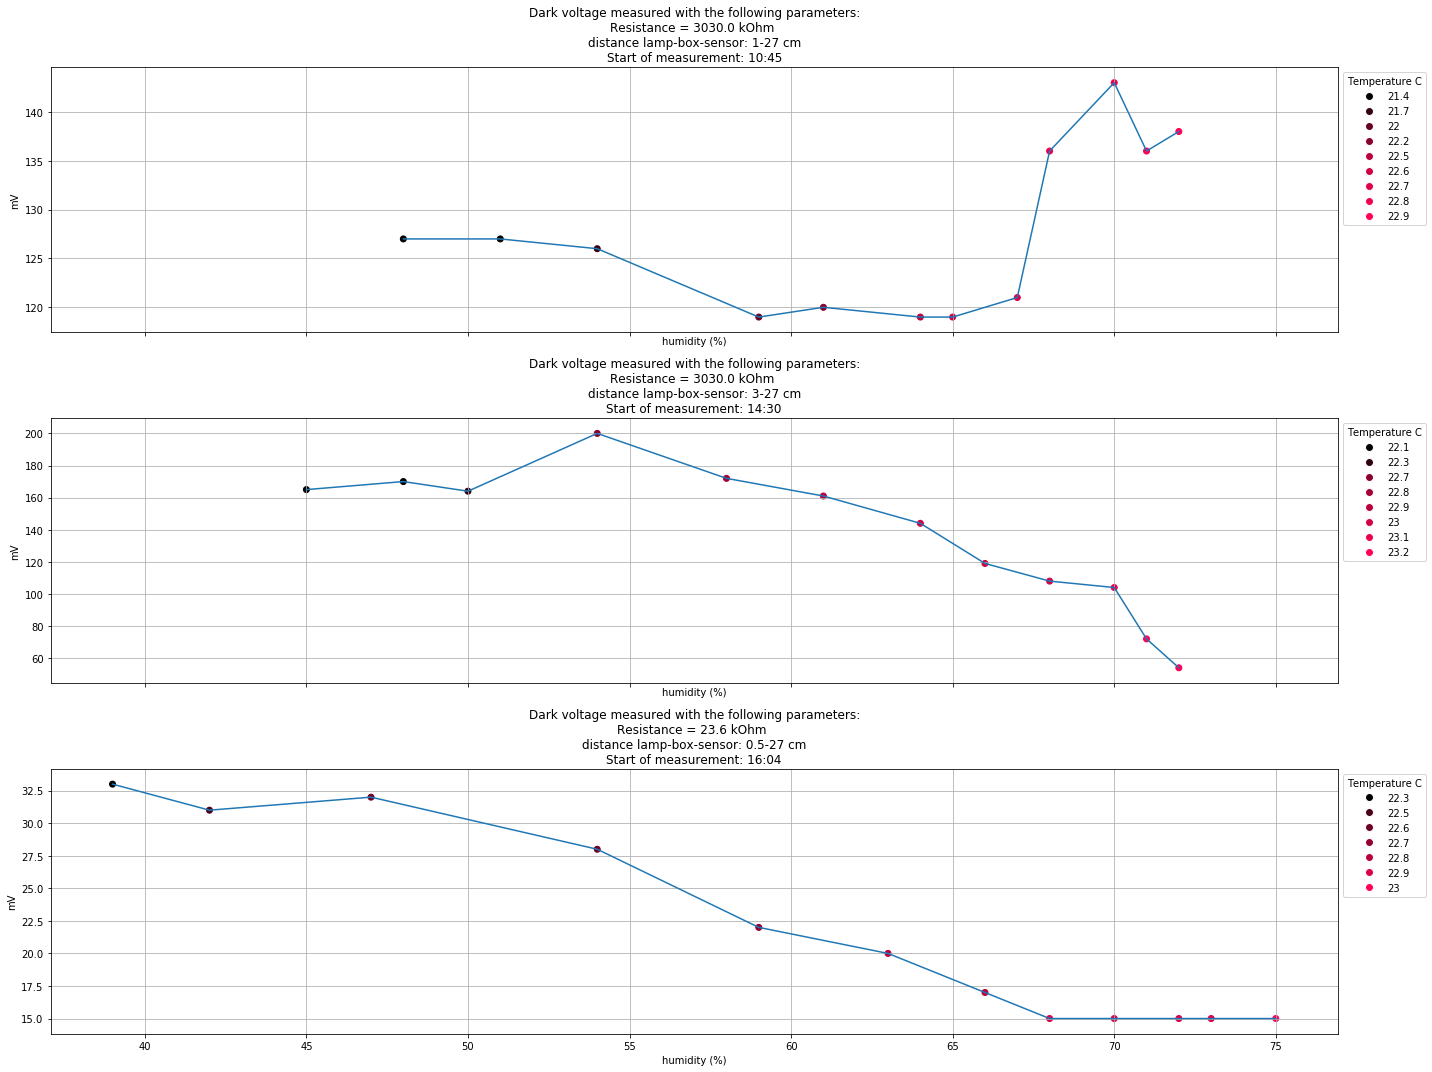

In [6]:
fig, axs = plt.subplots(len(data), figsize=(20, 15), sharex=True)

for i in range(len(data)):
    x = data[i]["humidity"]
    y = data[i]["dark_voltage"]
    temp = data[i]["temperature"]
    color_dict, color = color_magic(temp)
    axs[i].plot(x, y)
    axs[i].scatter(x, y, c=color)
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in
               color_dict.items()]
    axs[i].legend(title='Temperature C', handles=handles, bbox_to_anchor=(1, 1), loc='upper left')

    axs[i].set_title(f'Dark voltage measured with the following parameters:\n'
                     f'Resistance = {data[i]["resistor"] / 1000} kOhm \n'
                     f'distance lamp-box-sensor: {data[i]["distance_lamp_to_box"]}-{data[i]["distance_box_to_detector"]} cm\n'
                     f'Start of measurement: {data[i]["start_test"]}')
    axs[i].grid()
    axs[i].set_xlabel(f'humidity (%)')
    axs[i].set_ylabel('mV')

# axs[0].set_ylim([1785, 1840])
# axs[1].set_ylim([1585, 1640])
# axs[2].set_ylim([605, 660])

plt.tight_layout()
plt.savefig("dark_voltage")
plt.show()

Here I will start with the plots and data I got for the simulations
This is all based upon the WIKIPEDIA_DATA_TESTS in github.

I will start with some data that I need to load in:

also I will be importing some stuff to make 3D plots

choosing the wavelength as well, this could be any out of the WIKI_get_workable_absorption_coeff_water.

This loads all the possible wavelength:attenuation factors

In [7]:
# I need to get some fancy 3d tools, thats why this is imported
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# choosing our wavelength
wavelength = 940e-9

absorption_coefficient_water = WIKI_get_workable_absorption_coeff_water()[wavelength]
list_wavelengths = WIKI_workable_available_wavelengths()

I will start with (TEST_7) 

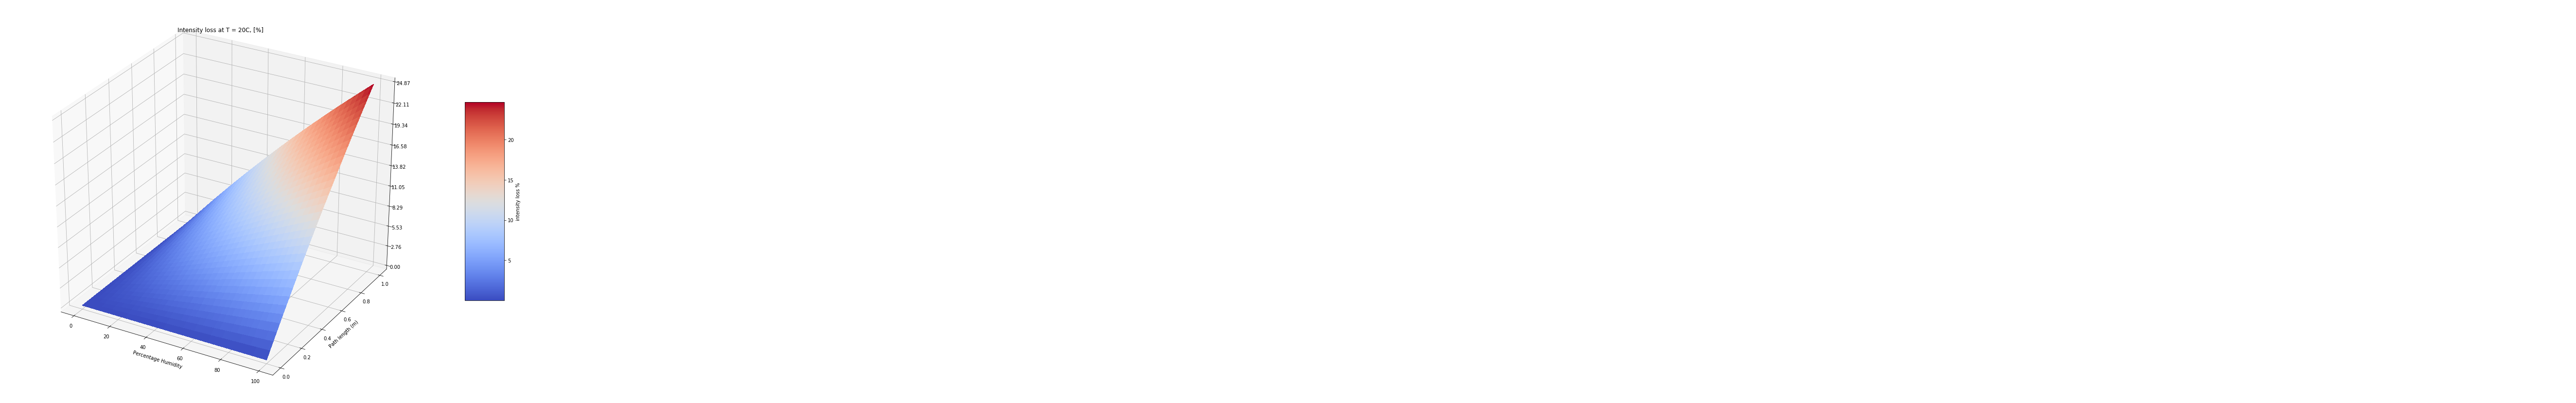

In [8]:
# choosing our wavelength
wavelength = 940e-9

T = 20
start_intensity = 0.100  # Watt/cm2

# lists needed for the plot
list_humidity = make_2d_humidity_list(101, 101)  # %
list_path_length = make_2d_path_length_list(101, 101)  # meter

list_intensity_loss = np.zeros((101, 101))

for i in range(len(list_humidity[0, :])):
    for j in range(len(list_path_length[0, :])):
        max_intensity_loss = WIKI_find_intensity_loss(start_intensity, list_path_length[j, 0],
                                                      absorption_coefficient_water, list_humidity[0, i], T)

        list_intensity_loss[i,j] = (max_intensity_loss/start_intensity)*100

list_intensity_loss = 100 - list_intensity_loss

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(list_humidity, list_path_length, list_intensity_loss, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5, label='intensity loss %')

plt.title(f'Intensity loss at T = {T}C, [%]')
plt.ylabel('Path length (m)')
plt.xlabel('Percentage Humidity')

plt.savefig("intensity_loss")
plt.show()

Now (TEST_8)
but here we use N = 100000 to speed it up

In [9]:
# choosing our wavelength
wavelength = 940e-9

random_temperature = True  # if you want to look at a certain temperature set this to False
start_intensity = 0.100  # Watt/cm2
path_length = 0.2  # meter

# decimals rounded, defaults to .1 mW
decimal_round = 4

# number of iterations
N = 100000
if not random_temperature:
    T = 10

error_list = []

for i in range(N):
    REAL_humidity = np.random.randint(0, 100)  # %
    if random_temperature:
        T = np.random.randint(-20, 60)

    concentration_water = WIKI_absorption_coefficient_air_composition_max_humidity_at_T(absorption_coefficient_water, T)

    max_intensity_loss = measure_intensity(start_intensity, concentration_water, path_length)

    random_intensity = ((max_intensity_loss - start_intensity) * REAL_humidity / 100) + start_intensity

    # to make this work as a real life situation, we cannot measure at 10 decimals
    random_intensity = round(random_intensity, decimal_round)

    humidity = WIKI_find_humidity_from_intensity_at_T(start_intensity, random_intensity, path_length,
                                                 absorption_coefficient_water, T)

    error_list.append(abs(humidity-REAL_humidity))


print(f"\nThe average error for {decimal_round} decimals W/cm2 with random temperature for wavelength {wavelength*1e9} nm is: \n"
      f"{sum(error_list)/len(error_list)} %")


The average error for 4 decimals W/cm2 with random temperature for wavelength 940.0 nm is: 
2.1318539248780497 %


TEST 9 but with N = 10.000, because 100.000 takes a long time

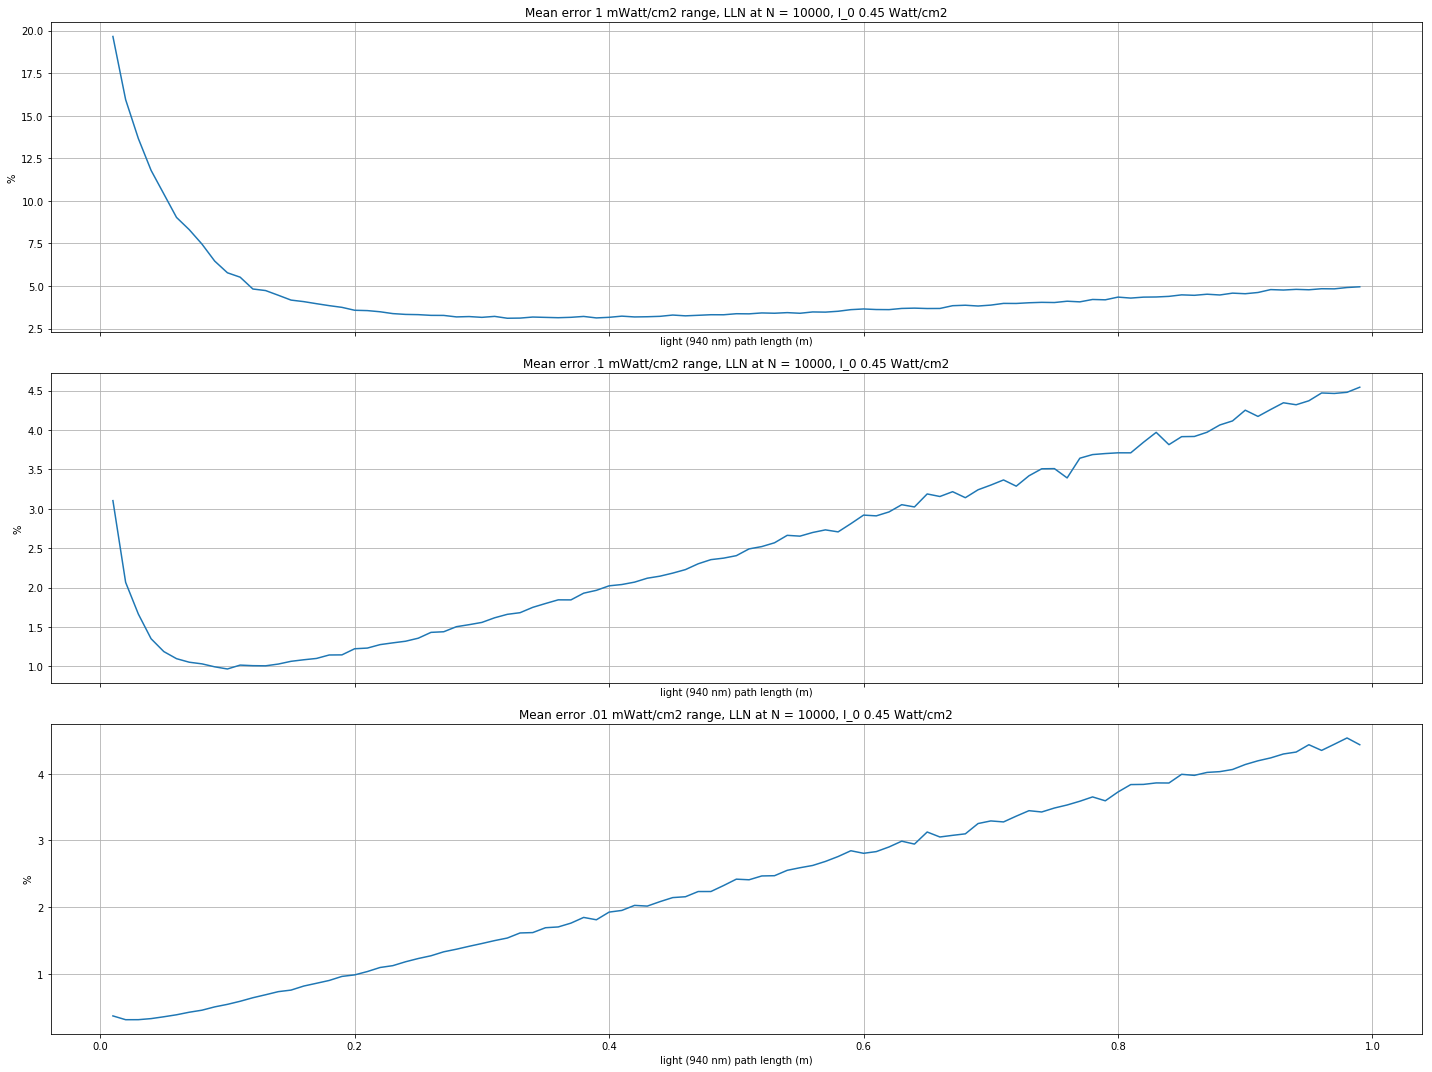

In [10]:
# choosing our wavelength
wavelength = 940e-9

start_intensity = 1.8/4  # Watt/cm2
path_length_list = make_2d_path_length_list(101, 101)  # meter
path_length_list = path_length_list[:,:3]
path_length_list = path_length_list[1:,:] # dont want the the path length of 0

# decimals rounded
decimal_round_list = make_2d_decimal_list(100)

# number of iterations
N = 10000

# if we want to control the temperature, we do that here
random_temperature = True
if not random_temperature:
    T = 10

error_list = np.zeros((100,3))

for i in range(len(path_length_list[:,0])):
    for j in range(len(decimal_round_list[0,:])):
        temp_error_list = []
        for _ in range(N):
            REAL_humidity = np.random.randint(0, 100)  # %
            if random_temperature:
                T = np.random.randint(-20, 60)

            concentration_water = WIKI_absorption_coefficient_air_composition_max_humidity_at_T(absorption_coefficient_water, T)

            max_intensity_loss = measure_intensity(start_intensity, concentration_water, path_length_list[i, 0])

            random_intensity = ((max_intensity_loss - start_intensity) * REAL_humidity / 100) + start_intensity

            #measuring at different decimals (3,4,5)
            random_intensity = round(random_intensity, int(decimal_round_list[0,j]))

            humidity = WIKI_find_humidity_from_intensity_at_T(start_intensity, random_intensity, path_length_list[i,0],
                                                         absorption_coefficient_water, T)

            temp_error_list.append(abs(humidity-REAL_humidity))
        error_list[i,j] = sum(temp_error_list)/len(temp_error_list)

error_list = error_list[1:,:] # first row are nan

# making the plots
fig, axs = plt.subplots(3, 1, sharex='col', figsize=(20, 15))
axs[0].plot(path_length_list[:-1,0], error_list[:,0])
axs[0].set_title(f"Mean error 1 mWatt/cm2 range, LLN at N = {N}, I_0 {start_intensity} Watt/cm2")

axs[1].plot(path_length_list[:-1,0], error_list[:,1])
axs[1].set_title(f"Mean error .1 mWatt/cm2 range, LLN at N = {N}, I_0 {start_intensity} Watt/cm2")

axs[2].plot(path_length_list[:-1,0], error_list[:,2])
axs[2].set_title(f"Mean error .01 mWatt/cm2 range, LLN at N = {N}, I_0 {start_intensity} Watt/cm2")

for i in range(3):
    axs[i].grid()
    axs[i].set_xlabel(f'light ({wavelength*1e9:.0f} nm) path length (m)')
    axs[i].set_ylabel('%')

plt.tight_layout()
plt.savefig("error_plots")
plt.show()

Now for the final plot (TEST16)

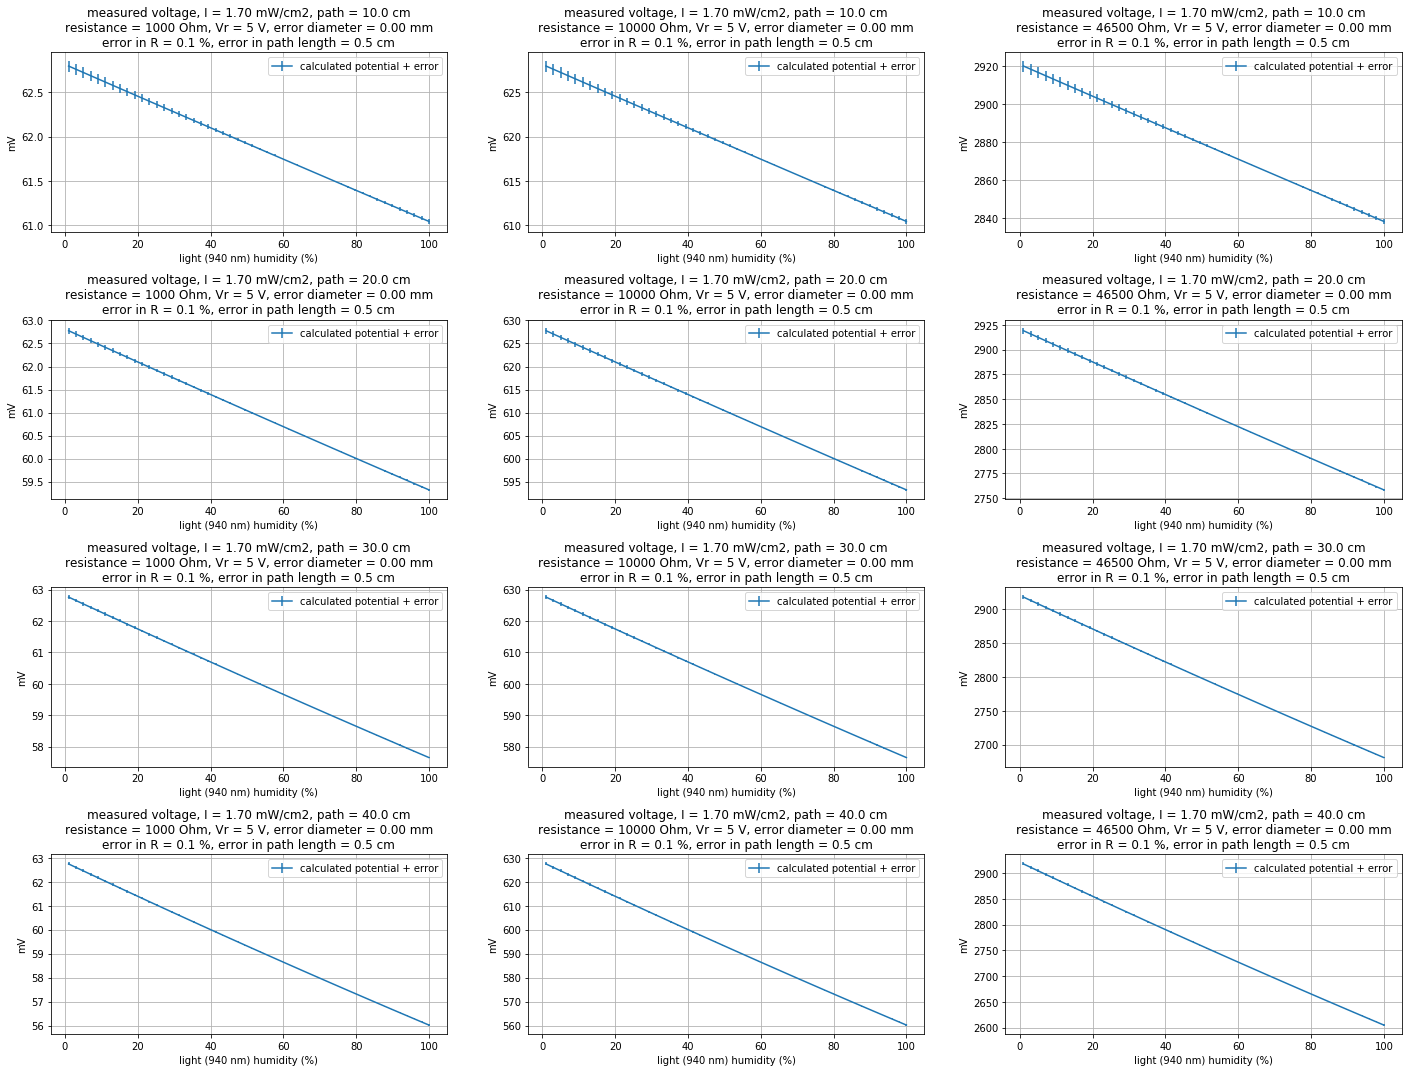

In [11]:
"""this py file tests the whole system and its variables"""

# system variables

laser_power = [3]  # mWatt

diameter_laser = [15]  # mm

laser_path_length = np.arange(0.1, .5, .1)  # m

resistance_resistor = [1e3, 1e4, 46.5e3]  # Ohm

relative_spectral_sensitivity = 1  # 940nm

# angle_laser_beam_on_detector = 0 # degree

reverse_voltage = 5

resistor_error = 0.001

path_length_error = 0.005  # m = .5 cm

diameter_laser_error = 0  # mm

# |---- data ----|

absorption_coefficient_water = WIKI_get_workable_absorption_coeff_water()

wavelength = 940e-9

temperature = 20  # C

humidity = np.linspace(1, 100)  # %

# |---- empty list for plots ----|

y = np.zeros((len(laser_path_length), len(humidity), len(resistance_resistor)))
error_low = y.copy()
error_high = y.copy()
error_difference = y.copy()
intensity = []


# |---- calculations ----|

for power in laser_power:
    for diameter in range(len(diameter_laser)):
        surface_area_laser = np.pi * (diameter_laser[diameter] / 2) ** 2  # mm2

        surface_area_laser_low = np.pi * ((diameter_laser[diameter] - diameter_laser_error) / 2) ** 2  # mm2
        surface_area_laser_high = np.pi * ((diameter_laser[diameter] + diameter_laser_error) / 2) ** 2  # mm2

        surface_area_detector = 6.5  # mm2
        intensity_at_laser_tip = power / surface_area_laser  # mWatt/mm2

        intensity_at_laser_tip_low = power / surface_area_laser_low  # mWatt/mm2
        intensity_at_laser_tip_high = power / surface_area_laser_high  # mWatt/mm2

        intensity_at_laser_tip *= 100  # mWatt/cm2
        intensity_at_laser_tip_low *= 100  # mWatt/cm2
        intensity_at_laser_tip_high *= 100  # mWatt/cm2

        intensity.append(intensity_at_laser_tip)

        for hum in range(len(humidity)):
            # |---- humidity calculations ----|
            for i in range(len(laser_path_length)):
                max_attenuation = WIKI_absorption_coefficient_air_composition_max_humidity_at_T(
                    absorption_coefficient_water[wavelength], temperature)  # c_max * a

                attenuation = (humidity[hum] / 100) * max_attenuation # c * a
                # attenuation /= absorption_coefficient_water[wavelength]

                light_at_detector = measure_intensity(intensity_at_laser_tip, attenuation, laser_path_length[i])

                light_at_detector_low_error = measure_intensity(intensity_at_laser_tip_low, attenuation, laser_path_length[i] - path_length_error)
                light_at_detector_high_error = measure_intensity(intensity_at_laser_tip_high, attenuation, laser_path_length[i] + path_length_error)

                # |---- calculating the current this induces ----|

                induced_current = photodetector_1(light_at_detector) * relative_spectral_sensitivity

                induced_current_low_error = photodetector_1(light_at_detector_low_error) * relative_spectral_sensitivity
                induced_current_high_error = photodetector_1(light_at_detector_high_error) * relative_spectral_sensitivity

                # the plot data
                y[i, hum, :] = induced_current
                error_low[i, hum, :] = induced_current_low_error
                error_high[i, hum, :] = induced_current_high_error

# more calculations
resistor_measurement = y.copy()

for i in range(len(resistance_resistor)):
    resistor_measurement[:, :, i] *= resistance_resistor[i]


voltage_measured = resistor_measurement  # this is sloppy, i know

# check if the voltage exceeds reverse voltage
for i in range(len(voltage_measured[:, 0, 0])):
    for j in range(len(voltage_measured[0, :, 0])):
        for k in range(len(voltage_measured[0, 0, :])):

            if voltage_measured[i, j, k] > reverse_voltage:
                voltage_measured[i, j, k] = reverse_voltage

for i in range(len(resistance_resistor)):
    low_point = (resistance_resistor[i] - (resistance_resistor[i] * resistor_error))
    high_point = (resistance_resistor[i] + (resistance_resistor[i] * resistor_error))
    error_low[:, :, i] *= low_point
    error_high[:, :, i] *= high_point
    error_difference[:, :, i] = abs(error_high[:, :, i] - error_low[:, :, i])

# check if the voltage exceeds reverse voltage
for i in range(len(voltage_measured[:, 0, 0])):
    for j in range(len(voltage_measured[0, :, 0])):
        for k in range(len(voltage_measured[0, 0, :])):

            if error_low[i, j, k] > reverse_voltage:
                error_low[i, j, k] = reverse_voltage
            if error_high[i, j, k] > reverse_voltage:
                error_high[i, j, k] = reverse_voltage

for i in range(len(resistance_resistor)):
    error_difference[:, :, i] = abs(error_high[:, :, i] - error_low[:, :, i])

voltage_measured *= 1e3  # to make it into mV
error_low *= 1e3
error_high *= 1e3
error_difference *= 1e3 / 2

# lets look at the difference
differences = np.zeros(voltage_measured.shape)

for i in range(len(voltage_measured[:, 0, 0])):
    for j in range(len(voltage_measured[0, :, 0])-1):
        for k in range(len(voltage_measured[0, 0, :])):
            differences[i, j, k] = abs(voltage_measured[i, j, k] - voltage_measured[i, j+1, k])

# plot

fig, axs = plt.subplots(len(laser_path_length), len(resistance_resistor), figsize=(20, 15))

for i in range(len(laser_path_length)):
    for j in range(len(resistance_resistor)):
        axs[i, j].errorbar(humidity, voltage_measured[i, :, j], yerr=error_difference[i, :, j],
                           fmt='-', label='calculated potential + error')
        axs[i, j].set_title(
            f"measured voltage, I = {intensity[0]:.2f} mW/cm2, path = {laser_path_length[i] * 100:.1f} cm\n"
            f"resistance = {resistance_resistor[j]:.0f} Ohm, Vr = {reverse_voltage} V, error diameter = {diameter_laser_error:.2f} mm\n"
            f"error in R = {resistor_error*100:.1f} %, error in path length = {path_length_error*100:.1f} cm")
        axs[i, j].grid()
        axs[i, j].set_xlabel(f'light ({wavelength * 1e9:.0f} nm) humidity (%)')
        axs[i, j].set_ylabel('mV')
        axs[i, j].legend()


plt.tight_layout()
plt.savefig("final_simulation")
plt.show()